# 题目

本笔记包含力扣题目 [1515.服务中心的最佳位置](https://leetcode.cn/problems/best-position-for-a-service-centre/) 的求解动画演示代码。

### 运行环境

*笔记中的动画使用 [algviz算法动画引擎](https://algviz.com/) 渲染，环境配置请参考该链接：[https://algviz.com/cn/installation.html](https://algviz.com/cn/installation.html)*

*觉得对你有帮忙的话请给👉[algviz开源项目](https://github.com/zjl9959/algviz)👈点个 Star✨，遇到了问题也可以在这里 [报个bug](https://github.com/zjl9959/algviz/issues)！*

# 思路

该问题是运筹学里面[中心选址问题](https://zhuanlan.zhihu.com/p/124914964)的简化版本。注意读题可以发现，题目中输入的“客户”坐标是整数，但要求输出的服务中心坐标可以是小数，并且说`与真实值误差在 10e-5 之内的答案将被视作正确答案`。为什么要特别添加前面的说明呢？因为这是一道竞赛题，要求参赛者在一个半小时内给出答案，所以这里的说明看似是扩大了搜索空间，实际上是为了降低问题的难度。因为解的类型是小数，所以解空间的边界是连续的，可以进一步猜测这里的问题应该都是[凸优化问题](https://www.zhihu.com/question/334515180)，我们可以尝试使用[局部搜索](https://zhuanlan.zhihu.com/p/387380011)的方法来寻找最优解。

我们首先在地图上面找一个位置作为初始解，有了初始解以后，带入公式 $\sum_{i=0}^{n-1}\sqrt{(x_{center}-x_{i})^{2} + (y_{center} - y_{i})^{2}}$ 求出当前解的目标值（即服务中心到所有客户的欧几里得距离）。之后是使用梯度下降法（或是爬山法）来搜索最优解，具体的梯度该如何设置呢？别忘了前面的距离公式！我们只需要求距离公式对 $x_{center}$ 和 $y_{center}$ 的偏导数即可（求导过程在[本题的官方题解](https://leetcode.cn/problems/best-position-for-a-service-centre/solution/fu-wu-zhong-xin-de-zui-jia-wei-zhi-by-leetcode-sol/)里有详细的证明）。

在选取初始解时，可以将所有客户坐标的几何中心作为初始的迭代位置，也可以随机选择一个点作为初始位置。之后使用爬山法来搜索初始解附近的位置，如果发现有新的位置能够找到更好的解，那么就将服务中心移动到当前位置并继续进行迭代搜索，算法的伪代码如下：

```python
cur_sol = init()
while not stop:
  for new_sol in neighbor(cur_sol):
    if obj(new_sol) < best_obj:
      cur_sol = new_sol
      break
return best_obj
```

这里面的 `neighbor()` 函数用来产生当前解附近的解，因为解空间是连续的，所以当前解附近必定有离最优解更近的解，我们只需要找到个这个解并继续做迭代即可。那么迭代的停止条件是什么呢？假如地图中只存在一个最优解，那么迭代的结果必然是让当前解无限的接近最优解，所以只需要设置一个阈值，并判断当前迭代步长是否小于该阈值即可（这里可以选择一个比题目中要求的误差更小的值作为阈值）。

In [8]:
import algviz, math
from matplotlib import pyplot
from IPython import display

Max_iter = 10
Threshold = 0.00001

class Solution:
  def getMinDistSum(self, positions):
    # 使用 algviz 对地图进行可视化。
    self.positions = positions
    self.viz = algviz.Visualizer(delay=0.5, layout=True)
    self.min_x = min(positions, key=lambda x:x[0])[0]
    self.max_x = max(positions, key=lambda x:x[0])[0]
    self.min_y = min(positions, key=lambda y:y[1])[1]
    self.max_y = max(positions, key=lambda y:y[1])[1]
    self.table = self.viz.createTable(self.max_y + 1, self.max_x + 1, cell_size=(15, 15), name='地图（蓝色为客户点，红色为服务中心）')
    pyplot.figure(dpi=80); pyplot.rcParams['font.sans-serif'] = ['simhei']; pyplot.rcParams['axes.unicode_minus']=False
    pyplot.xlabel('迭代步数'); pyplot.ylabel('当前距离')
    self.objs = list()
    self.update_display_flag = False
    for pos in positions:
      self.table.mark(algviz.color_light_blue, pos[1], pos[0], True)
    self.viz.display()
    # 选择地图中心点作为服务中心的初始位置。
    self.center_x = (self.min_x + self.max_x) * 0.5
    self.center_y = (self.min_y + self.max_y) * 0.5
    self.objs.append(self.getDistance(self.center_x, self.center_y))
    self.step = 1
    # 进行局部搜索。
    self.iter = 0
    while not self.canStop():
      self.iter += 1
      move = self.getDeltMove()
      if move == None:
        continue
      self.updateDisplay()
      self.center_x += move[0] * self.step
      self.center_y += move[1] * self.step
      self.objs.append(self.getDistance(self.center_x, self.center_y))
    self.updateDisplay()
    return min(self.objs)

  def getDeltMove(self):
    delt_moves = ((-1, 0), (1, 0), (0, -1), (0, 1))
    # 搜索四个方向的邻域动作
    for move in delt_moves:
      x = self.center_x + move[0]*self.step
      y = self.center_y + move[1]*self.step
      dist = self.getDistance(x, y)
      if dist < self.objs[-1]:
        self.table.mark(algviz.color_orange, round(x), round(y))
        return move
      self.table.mark(algviz.color_gray, round(x), round(y))
    # 减少跳跃步长
    self.step /= 2
    return None

  def getDistance(self, x, y):
    dist = 0
    for pos in self.positions:
      dist += math.sqrt((pos[0] - x) ** 2 + (pos[1] - y) ** 2)
    return dist
  
  def updateDisplay(self):
    # 由于显示精度问题，这里只显示中心值所在格点的坐标。
    self.table.removeMark(algviz.color_red)
    self.table.mark(algviz.color_red, round(self.center_x), round(self.center_y), True)
    pyplot.plot([i for i in range(len(self.objs))], self.objs, marker='o', color='green')
    if self.update_display_flag == False:
      display.display(pyplot.gcf(), display_id='fig1')
      self.update_display_flag = True
    else:
      display.update_display(pyplot.gcf(), display_id='fig1')
    self.viz.display()

  def canStop(self):
    return self.iter > Max_iter or self.step < Threshold

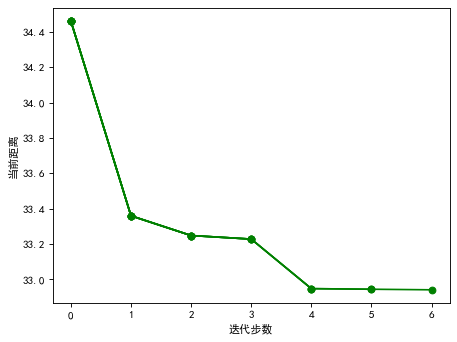

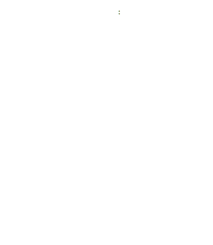

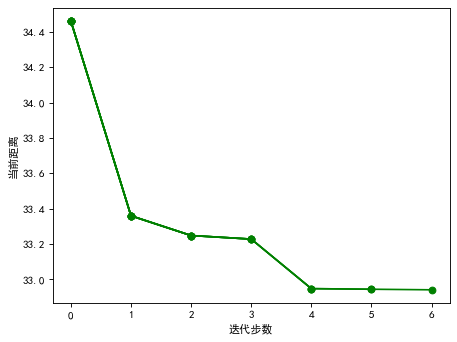

In [9]:
positions = [[0,1],[3,2],[4,5],[7,6],[8,9],[11,1],[2,12]]
solver = Solution()
solver.getMinDistSum(positions)
solver.viz.layout(400)

上面的算法顺利的通过了所以测试，这依赖于一个假设：那就是该问题是一个凸优化问题！从上面的目标函数变化曲线可以看出来，曲线是一直在下降的，直到停留在最低点。但假如我们没法证明这是个凸优化问题，是否存在一种更通用的算法可以解决该问题呢？答案是有的，就是模拟退火算法！算法的思路也很简单，就是为算法引入一定的随机性，让算法有一定的能力去跳出局部最优解。对上面的伪代码稍做改造即可：

```python
cur_sol = init()
while not stop:
  for new_sol in neighbor(cur_sol):
    delt = obj(new_sol) - best_obj
    threshold = math.exp((-delt - 1)/noise) # 计算随机因子
    if delt < 0 or random() < threshold
      cur_sol = new_sol
      noise -= step         # 噪声随时间减小（温度）
      break
return best_obj
```

这里引入了一个计算随机因子的公式 $e^{\frac{-delt-1}{noise}}$，公式里面的 `noise` 代表噪声或是温度的大小。可以理解为，在金属退火的过程中，随着金属表面的温度的降低，其内部粒子活性会呈现出一个指数下降的趋势。在算法刚开始运行时 `noise` 的值较大，那么当前解的变化趋向于随机移动，但随着 `noise` 的降低，算法接受较差的解的概率逐渐减小，最终退化成前面的爬山算法。这样做的目的是使算法能够更充分的探索解空间，所以对于非凸优化的问题，模拟退火算法通常能够比爬山法找到更优的解，在实际生活中也有着更加广泛的应用。

In [10]:
import random

class SimulatedAnnealingSolution(Solution):
    def __init__(self):
        super().__init__()
        random.seed(5)
        self.noise = 5
        self.delt_noise = 0.5

    def getDeltMove(self):
        delt_moves = ((-1, 0), (1, 0), (0, -1), (0, 1))
        self.table.removeMark(algviz.color_red)
        self.table.mark(algviz.color_red, round(self.center_x), round(self.center_y), True)
        # 搜索四个邻居点
        for move in delt_moves:
            x = self.center_x + move[0]*self.step
            y = self.center_y + move[1]*self.step
            dist = self.getDistance(x, y)
            delt = dist - self.objs[-1]
            threshold = math.exp((-delt - 1)/self.noise)
            # 以一定概率接收较差的解。
            if delt < 0 or random.random() < threshold:
                self.noise = max(0.1, self.noise - self.delt_noise)
                self.table.mark(algviz.color_orange, round(x), round(y))
                return move
            self.table.mark(algviz.color_gray, round(x), round(y))
        self.noise = max(0.1, self.noise - self.delt_noise)
        return None

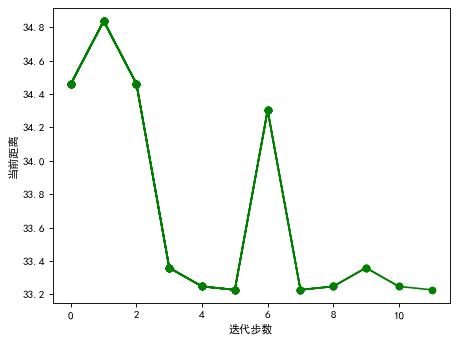

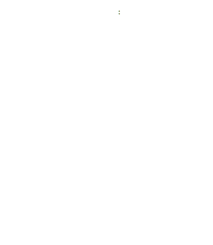

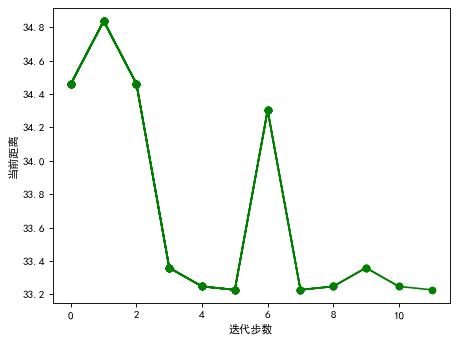

In [11]:
positions = [[0,1],[3,2],[4,5],[7,6],[8,9],[11,1],[2,12]]
solver = SimulatedAnnealingSolution()
solver.getMinDistSum(positions)
solver.viz.layout(300)